# Setup and Install

In [ ]:
import os
import glob
import shutil
import random
import gc
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO, RTDETR, settings
from IPython.display import Image, display
from google.colab import drive
from roboflow import Roboflow
import datetime

In [ ]:
!pip install -q roboflow ultralytics # Install required libraries

drive.mount('/content/drive')

DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/Deep_Learning' # Root directory in Google Drive
DRIVE_WEIGHTS_DIR = os.path.join(DRIVE_PROJECT_ROOT, 'weights')
DRIVE_RUNS_DIR = os.path.join(DRIVE_PROJECT_ROOT, 'runs')

# Create directories if they don't exist
os.makedirs(DRIVE_WEIGHTS_DIR, exist_ok=True)
os.makedirs(DRIVE_RUNS_DIR, exist_ok=True)

print(f" Setup Complete. GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 139.1 MB/s eta 0:00:00
Mounted at /content/drive
 Setup Complete. GPU Available: True
   GPU Name: NVIDIA A100-SXM4-40GB


# Download and Merge Datasets

In [ ]:
settings.update({'datasets_dir': '/content/datasets'}) # Set datasets directory to Colab local disk for speed at first

def download_data_fast():
    print(" Downloading dataset from Roboflow to local Colab disk")

    rf = Roboflow(api_key="8gFJp7Eu2sWslubjUHwI") # API Key from Roboflow
    project = rf.workspace("visualizan2").project("c1-zhnfm")
    version = project.version(1)

    dataset = version.download("yolov11") # Download in YOLOv11 format

    print(f" Dataset ready at: {dataset.location}")
    return dataset, f"{dataset.location}/data.yaml"


# Execute Download
dataset_obj, data_yaml_path = download_data_fast()

custom_dataset = '/content/custom_dataset' # Path to local dataset we add in Colab

def merge_datasets(source_root, target_root):
    # Iterate through 'train', 'valid', and 'test' sets
    for subset in ['train', 'valid', 'test']:
        for folder in ['images', 'labels']:
            source_dir = os.path.join(source_root, subset, folder)
            target_dir = os.path.join(target_root, subset, folder)

            # Check if source directory exists
            if os.path.exists(source_dir) and os.path.exists(target_dir):
                files = os.listdir(source_dir)

                for file_name in files:
                    full_file_name = os.path.join(source_dir, file_name)
                    if os.path.isfile(full_file_name):
                        shutil.copy(full_file_name, target_dir)
            else:
                pass

# Check if manual path exists and run the merge
if os.path.exists(custom_dataset):
    merge_datasets(custom_dataset, dataset_obj.location)
else:
    print(f"WARNING: local dataset path not found: {custom_dataset}. Proceeding with Roboflow data only.")


loading Roboflow workspace...
loading Roboflow project...
 Dataset ready at: /content/C1-1


# Train RT-DETR for 50 Epochs

In [ ]:
from ultralytics import RTDETR
import datetime

# Configuration for RT-DETR
MODEL_TYPE = 'rtdetr-l.pt'
EPOCHS = 50
BATCH_SIZE = 16
IMG_SIZE = 640

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M") # Timestamp for unique run name
run_name = f"chess_rtdetr_l_{timestamp}"

print(f"\n{'='*20} Starting Training: {run_name} {'='*20}")

if torch.cuda.is_available():
    torch.cuda.empty_cache() # Clear GPU cache before training

# Load Model
model = RTDETR(MODEL_TYPE)

# Train
results = model.train(
    data=data_yaml_path,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    optimizer='AdamW',
    lr0=0.0001,
    cos_lr=True,
    project='/content/runs/detect',
    name=run_name,
    seed=42,
    patience=10,
    plots=True,
    exist_ok=True,
    workers=16
)

print(f"Training Finished. Results saved locally to /content/runs/detect/{run_name}")


==================== Starting Training: chess_rtdetr_l_20260101_1829 ====================
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/C1-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=chess_rtdetr_l_20260101_1829, nbs=64, 

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       1/50      16.3G     0.9021      1.032     0.2162        444        640: 100% ━━━━━━━━━━━━ 427/427 2.3it/s 3:02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 3.6it/s 17.1s
                   all       1960      43525      0.037      0.191     0.0263     0.0129

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       2/50      17.6G     0.7996      1.052      0.143        572        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       2/50      18.3G     0.5987      1.129     0.1207        426        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.9it/s 12.7s
                   all       1960      43525      0.062      0.337      0.057     0.0336

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       3/50      18.4G     0.5692      1.152     0.1141        351        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       3/50      18.4G     0.5424      1.034     0.1109        513        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.403      0.511      0.312      0.201

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       4/50      18.5G      0.463     0.8649     0.1068        383        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       4/50      18.5G     0.5445     0.6475      0.115        572        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.688      0.699      0.591      0.382

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       5/50      18.6G     0.9237     0.5889     0.2422        589        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       5/50      18.6G     0.5304     0.5775     0.1148        380        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.767      0.759      0.701      0.474

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       6/50      18.7G     0.5248     0.5687     0.1043        529        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       6/50      18.7G     0.5175     0.5302     0.1117        261        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.839      0.806      0.769      0.518

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       7/50      18.7G     0.4578     0.5571    0.06827        713        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       7/50      19.5G     0.5088     0.5069     0.1098        625        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.849      0.824      0.801      0.549

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       8/50      19.6G      0.521      0.506     0.1094        669        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       8/50      19.6G     0.5046     0.4888     0.1072        370        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.862      0.836      0.814      0.562

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       9/50      19.7G      0.686     0.4809     0.1232        643        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


       9/50      19.7G     0.4978     0.4788     0.1054        471        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.872      0.838       0.83      0.575

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      10/50      19.7G     0.4311     0.5238    0.07904        496        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      10/50      19.7G     0.4894     0.4739      0.103        571        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.868       0.84      0.829      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      11/50      19.8G     0.6354     0.4419     0.1479        528        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      11/50      19.8G     0.4715     0.4666    0.09831        423        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.879      0.827      0.837      0.587

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      12/50      13.6G     0.6161     0.4776     0.1208        601        640: 0% ──────────── 0/427  0.5s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      12/50      13.6G     0.4742     0.4602    0.09867        328        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.889      0.834      0.844      0.591

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      13/50      13.6G     0.5038     0.4372     0.0939        393        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      13/50      14.8G     0.4726     0.4573    0.09713        358        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.894      0.842      0.844      0.595

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      14/50      14.8G     0.4438     0.4875    0.09227        513        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      14/50      14.8G     0.4615     0.4573    0.09382        536        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.904      0.842      0.857      0.595

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      15/50      14.8G     0.6813     0.4616     0.1664        437        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      15/50      14.9G     0.4608     0.4558    0.09328        450        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.906      0.836      0.848      0.599

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      16/50        15G     0.6544     0.4327     0.1195        456        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      16/50        15G     0.4521     0.4528    0.09163        480        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.908      0.828      0.853      0.604

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      17/50      15.1G       0.69     0.5049     0.1471        405        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      17/50      15.1G     0.4489     0.4514    0.08973        388        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.904      0.839      0.852      0.605

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      18/50      15.2G     0.5874      0.432      0.101        638        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      18/50      15.2G     0.4416     0.4496    0.08812        399        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.914      0.844      0.859      0.605

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      19/50      15.2G     0.4199     0.4659    0.09157        444        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      19/50      15.3G     0.4364     0.4485    0.08748        691        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.928       0.84      0.862      0.613

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      20/50      15.3G     0.3735     0.4592    0.07677        420        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      20/50      15.4G     0.4383     0.4433    0.08761        403        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.921      0.841      0.862      0.618

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      21/50      15.4G      0.623     0.5253      0.145        421        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      21/50      15.4G     0.4358     0.4445     0.0873        453        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.927      0.841      0.866      0.617

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      22/50      15.5G     0.3565     0.4338    0.06037        465        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      22/50      15.5G     0.4316     0.4394    0.08618        585        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.926      0.834      0.867      0.621

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      23/50      15.6G     0.3202     0.4266    0.06886        365        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      23/50      15.8G     0.4338     0.4459    0.08635        544        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.925       0.84      0.867      0.622

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      24/50      15.9G       0.34     0.4205    0.08191        474        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      24/50      15.9G     0.4294     0.4419     0.0862        544        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.932      0.835       0.87      0.626

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      25/50        16G      0.396     0.4648    0.08869        420        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      25/50        16G     0.4215     0.4395    0.08279        546        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.926      0.844      0.867      0.625

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      26/50      16.1G     0.4589     0.4323    0.09513        522        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      26/50      16.5G     0.4147     0.4354     0.0813        429        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.923      0.844      0.864      0.623

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      27/50      16.5G     0.3925     0.4477    0.09148        425        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      27/50      16.6G       0.42     0.4345    0.08311        528        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.929      0.849      0.869      0.627

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      28/50      16.7G     0.5215     0.4448     0.1144        391        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      28/50      16.7G     0.4123     0.4324    0.08157        271        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.922      0.849       0.86      0.624

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      29/50      16.7G     0.4309      0.446     0.1021        436        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      29/50      16.8G      0.408     0.4302    0.08061        393        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.932      0.847      0.868      0.629

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      30/50      16.8G     0.3805     0.4052    0.08026        454        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      30/50      16.8G     0.4102     0.4315    0.08074        463        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.938      0.841      0.869      0.628

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      31/50      16.9G     0.3847     0.4407    0.07986        423        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      31/50      16.9G     0.4076     0.4277    0.07931        450        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.922      0.857      0.862      0.626

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      32/50        17G     0.4034     0.4297    0.08225        499        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      32/50        17G     0.3979     0.4253      0.077        346        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.937      0.843      0.866      0.628

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      33/50      17.1G     0.3667     0.4056     0.0816        479        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      33/50      17.1G     0.4038     0.4272    0.07883        386        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:40
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.933      0.851      0.864      0.628

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      34/50      17.2G     0.3623     0.4067    0.07537        534        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      34/50      17.2G     0.4036     0.4244    0.07772        388        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525       0.94      0.849      0.869      0.631

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      35/50      17.2G     0.4439     0.4554    0.09411        511        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      35/50      17.9G     0.3995     0.4233     0.0779        425        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.933      0.849      0.867      0.632

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      36/50        18G      0.418     0.4644    0.09681        328        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      36/50        18G      0.393     0.4224    0.07628        251        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.946      0.836       0.87      0.633

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      37/50        18G     0.4889      0.479     0.1014        421        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      37/50      18.1G     0.3943     0.4235    0.07695        525        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525       0.94      0.844      0.868      0.634

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      38/50      18.1G     0.3847     0.4379    0.06998        627        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      38/50      18.4G     0.3934     0.4234    0.07672        744        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525       0.94      0.852       0.87      0.636

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      39/50      18.4G     0.4071     0.4572    0.06025        596        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      39/50      18.5G     0.3922     0.4209    0.07607        354        640: 100% ━━━━━━━━━━━━ 427/427 2.6it/s 2:43
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.944      0.845      0.871      0.636

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      40/50      18.6G     0.3408     0.4169    0.06699        317        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      40/50      18.6G     0.3902     0.4203    0.07596        555        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.942      0.845      0.869      0.635
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      41/50      18.7G     0.3533     0.4027     0.0848        310        640: 0% ──────────── 0/427  1.5s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      41/50      18.7G     0.3618     0.4001    0.08297        462        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:38
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.939      0.849      0.871      0.636

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      42/50      18.7G     0.6571       0.51     0.1392        326        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      42/50      18.7G     0.3585     0.3992    0.08193        353        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.3s
                   all       1960      43525      0.935      0.855       0.87      0.637

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      43/50      18.8G     0.2988     0.3678    0.05228        318        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      43/50      18.8G     0.3576     0.3963    0.08061        377        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 12.9s
                   all       1960      43525      0.939      0.852      0.871      0.636

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      44/50      18.9G     0.2827     0.3615    0.06885        259        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      44/50      18.9G     0.3558     0.3956    0.08045        413        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.941      0.851      0.873      0.638

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      45/50        19G     0.3108     0.3621    0.05807        373        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      45/50        19G     0.3578     0.3953    0.08122        289        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.946      0.849      0.873      0.638

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      46/50      19.1G     0.3948     0.3956    0.07634        319        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      46/50      19.1G      0.355     0.3946    0.08039        429        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.2s
                   all       1960      43525      0.942      0.852      0.873      0.639

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      47/50      19.1G     0.3683     0.4153    0.08961        513        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      47/50      19.2G     0.3561     0.3959    0.08031        277        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.945       0.85      0.873      0.638

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      48/50      19.3G     0.3443     0.4195    0.09869        352        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      48/50      19.3G     0.3543     0.3933    0.07941        266        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.8it/s 13.0s
                   all       1960      43525      0.945      0.848      0.872      0.638

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      49/50      19.4G     0.4989     0.4466     0.1172        314        640: 0% ──────────── 0/427  0.3s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      49/50      19.4G     0.3557     0.3929    0.08021        284        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.7it/s 13.1s
                   all       1960      43525      0.947      0.848      0.873      0.639

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      50/50      19.5G      0.212     0.3437    0.04488        237        640: 0% ──────────── 0/427  0.4s

grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)


      50/50      19.5G     0.3542     0.3947    0.07877        231        640: 100% ━━━━━━━━━━━━ 427/427 2.7it/s 2:37
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.6it/s 13.4s
                   all       1960      43525      0.946       0.85      0.873      0.639

50 epochs completed in 2.429 hours.
Optimizer stripped from /content/runs/detect/chess_rtdetr_l_20260101_1829/weights/last.pt, 66.3MB
Optimizer stripped from /content/runs/detect/chess_rtdetr_l_20260101_1829/weights/best.pt, 66.3MB

Validating /content/runs/detect/chess_rtdetr_l_20260101_1829/weights/best.pt...
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
rt-detr-l summary: 310 layers, 32,008,400 parameters, 0 gradients, 103.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 62/62 4.1it/s 15.2s
                   all       1960      43525   

# Save Results to Drive

In [ ]:
import shutil

def backup_results():
    print("Backing up results to Google Drive")

    local_run_dir = f'/content/runs/detect/{run_name}'

    drive_dest_dir = os.path.join(DRIVE_RUNS_DIR, run_name)

    if os.path.exists(local_run_dir):
        # Copy the entire folder
        shutil.copytree(local_run_dir, drive_dest_dir)
        print(f"Full run directory copied to: {drive_dest_dir}")

        # Copy the best weights separately
        local_best_pt = os.path.join(local_run_dir, 'weights', 'best.pt')
        if os.path.exists(local_best_pt):
            drive_weights_path = os.path.join(DRIVE_WEIGHTS_DIR, f"best_{run_name}.pt")
            shutil.copy(local_best_pt, drive_weights_path)
            print(f" Best weights saved to: {drive_weights_path}")

        print("Backup Complete")
    else:
        print(f"Error: Local run directory not found: {local_run_dir}")

backup_results()

Backing up results to Google Drive
   Full run directory copied to: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20260101_1829
 Best weights saved to: /content/drive/MyDrive/Deep_Learning/weights/best_chess_rtdetr_l_20260101_1829.pt
Backup Complete


# Show Training Metrics

Inspecting results from: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20260101_1829
Test images found in Drive: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

==================== 1. TRAINING METRICS ====================

--- Loss and Metrics Curves ---


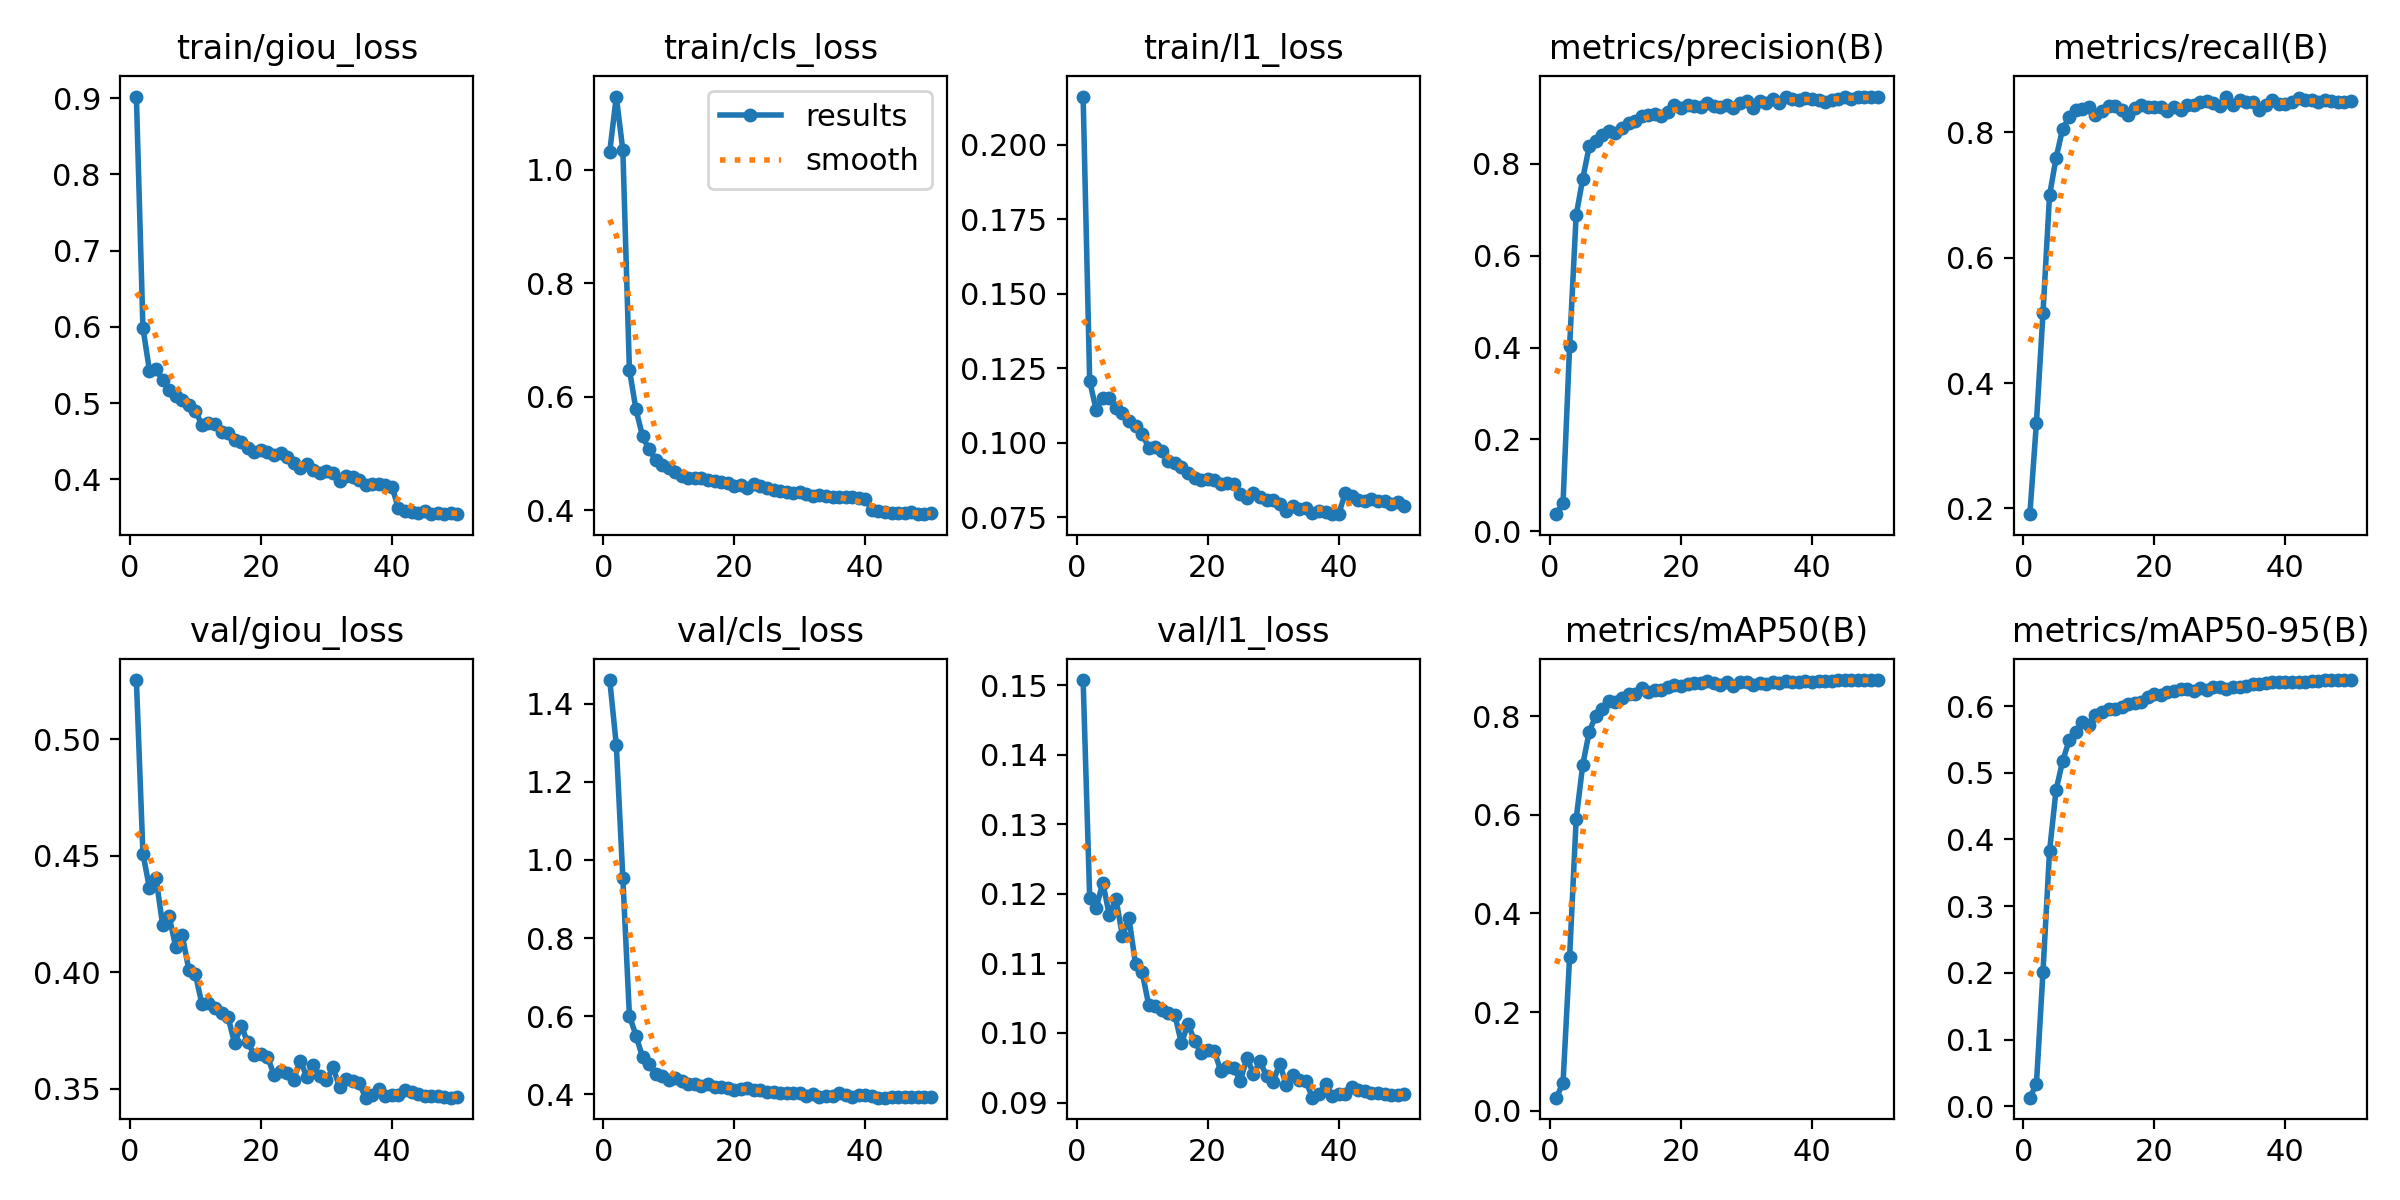


--- Confusion Matrix (Normalized) ---


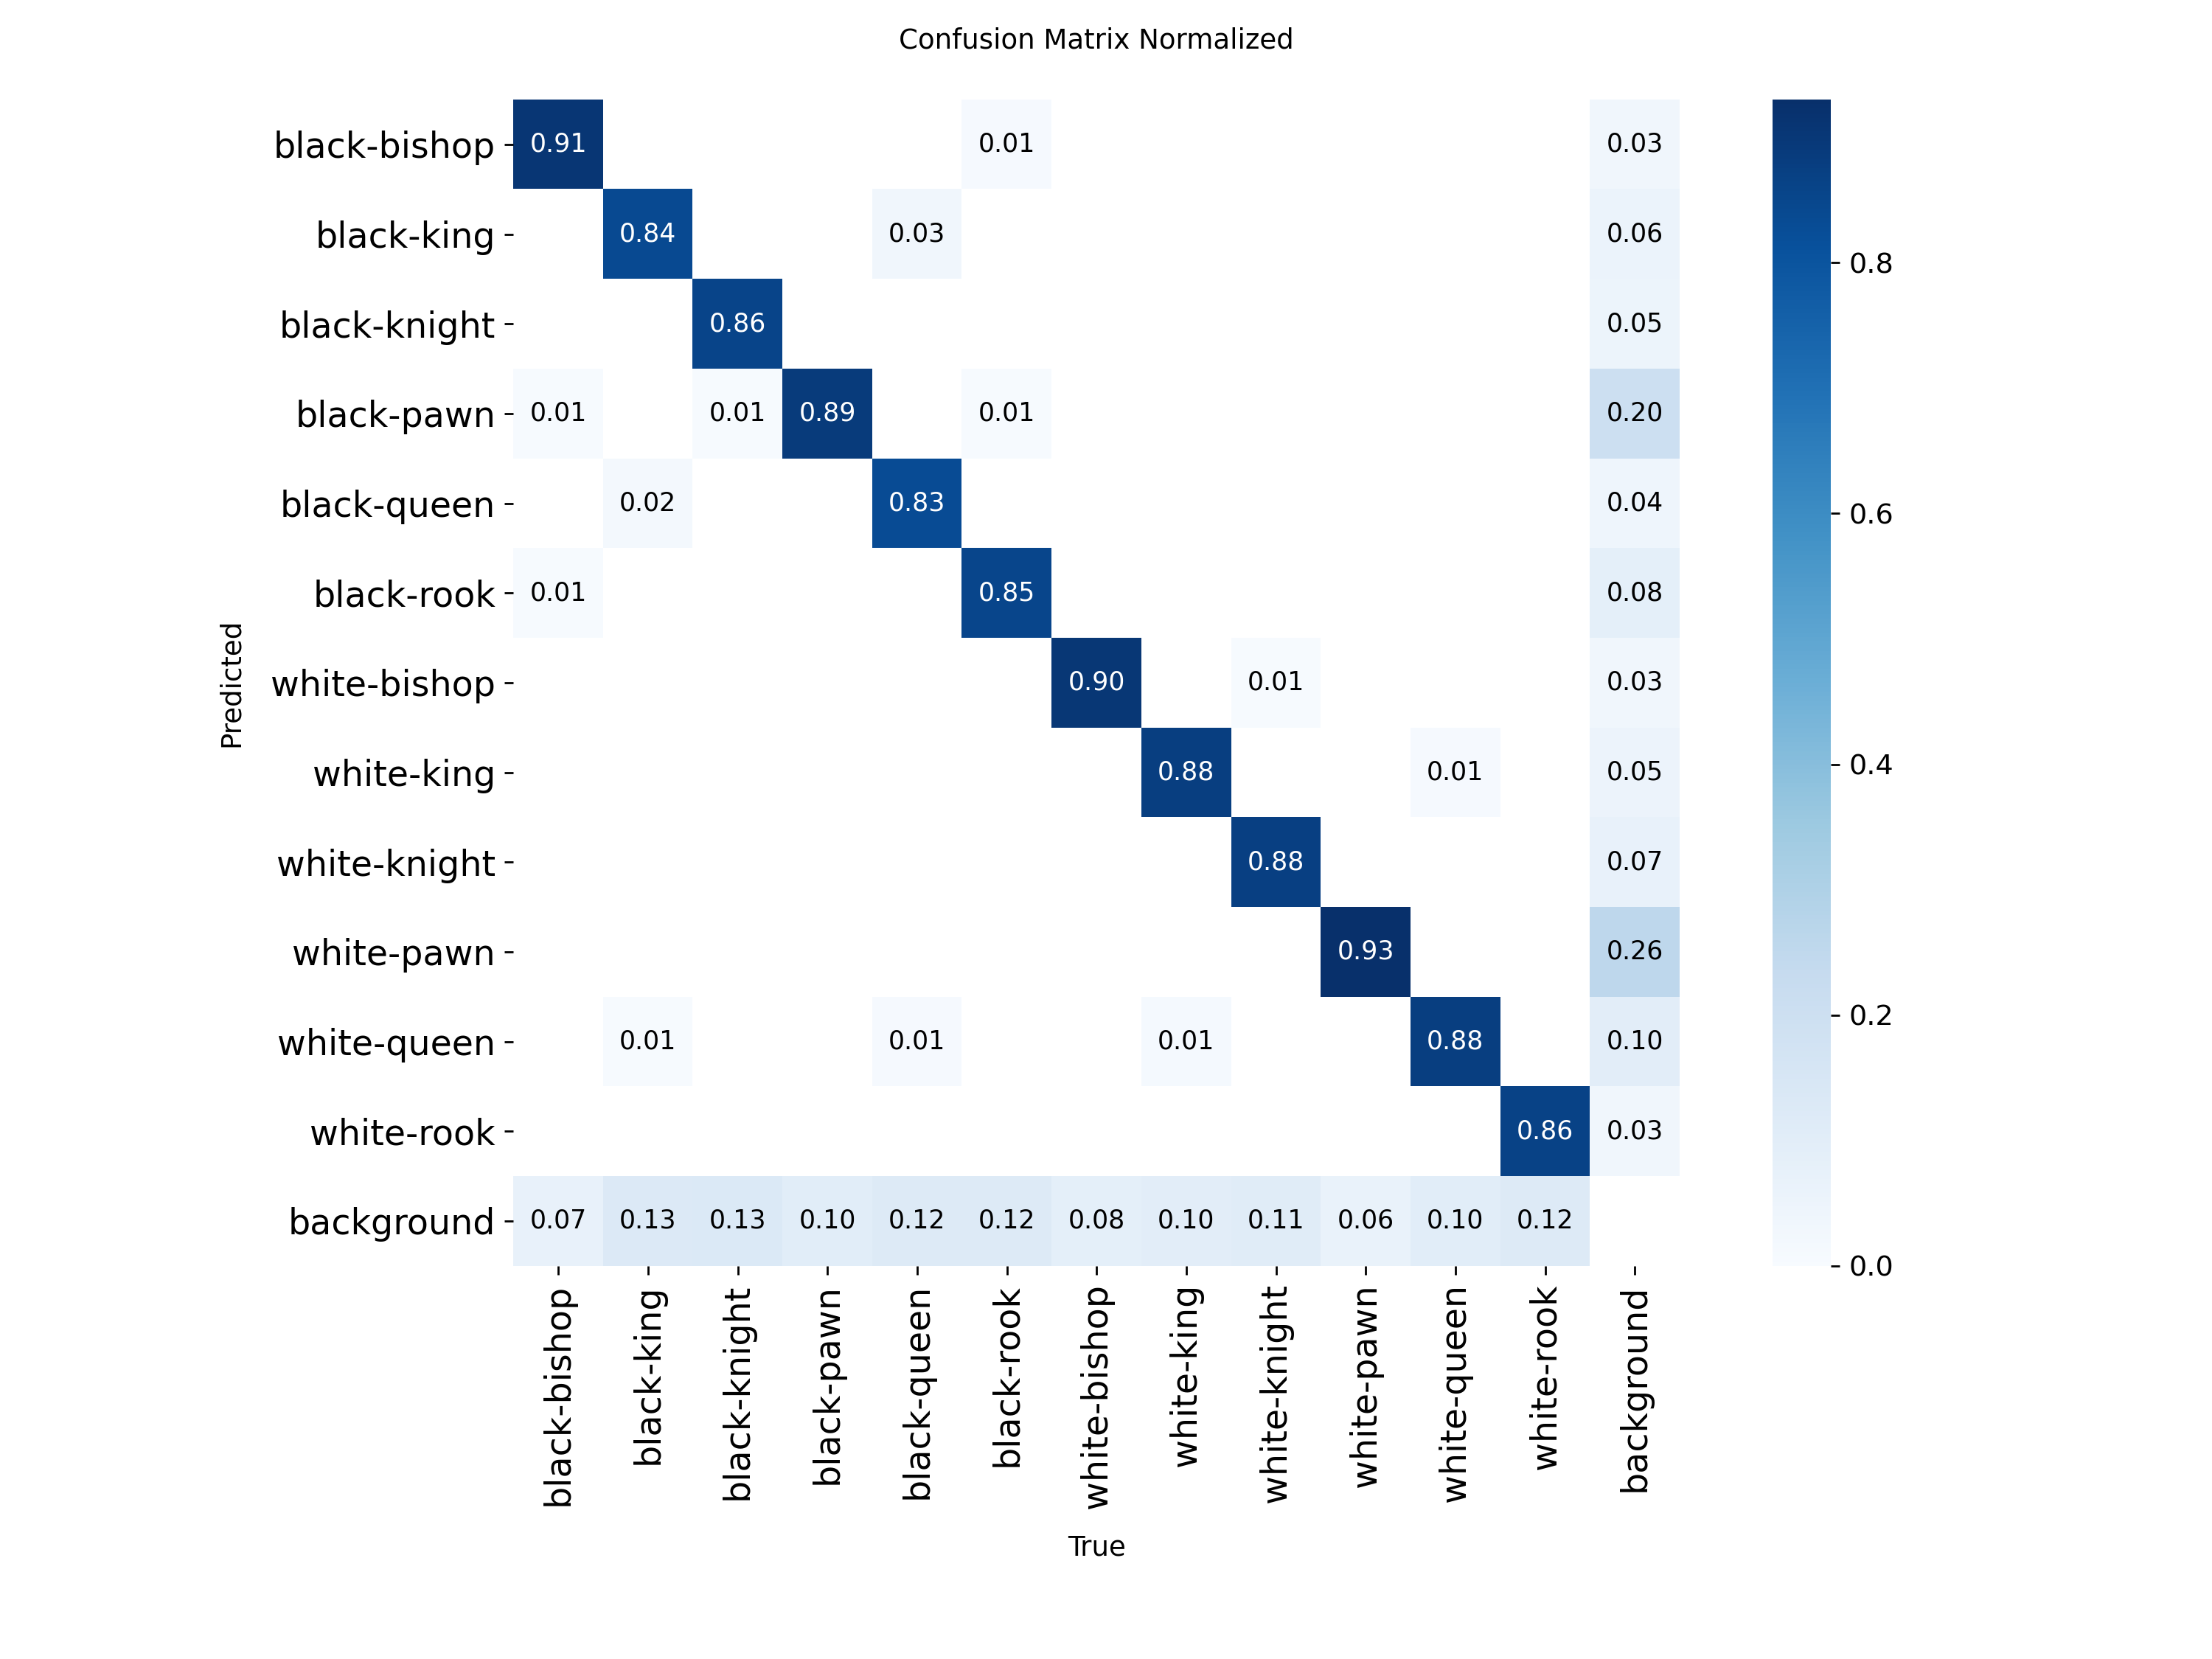


--- Dataset Labels ---


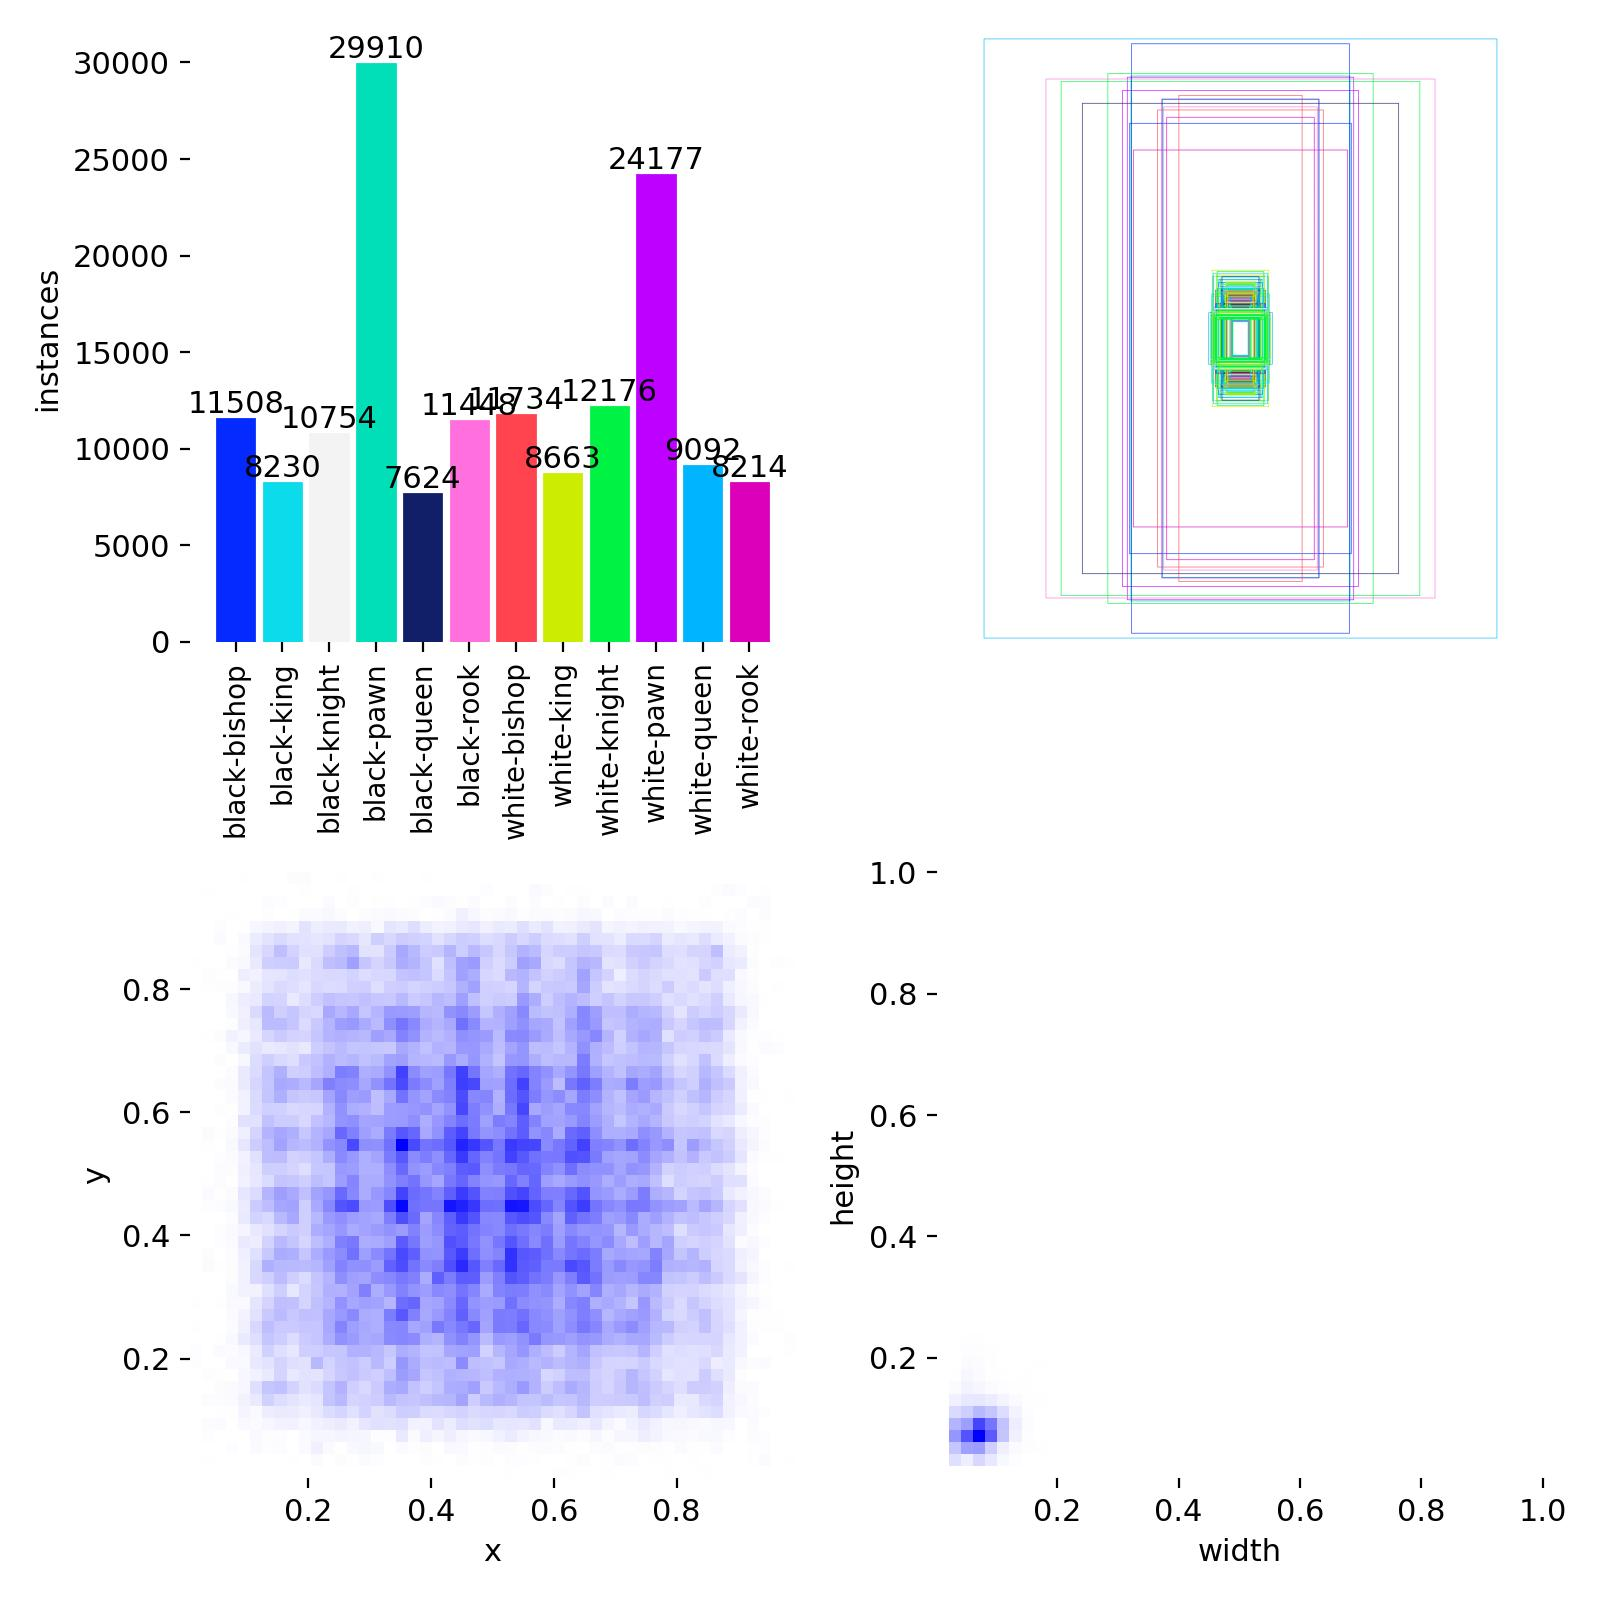


==================== 2. VISUAL PREDICTIONS (TEST SET) ====================


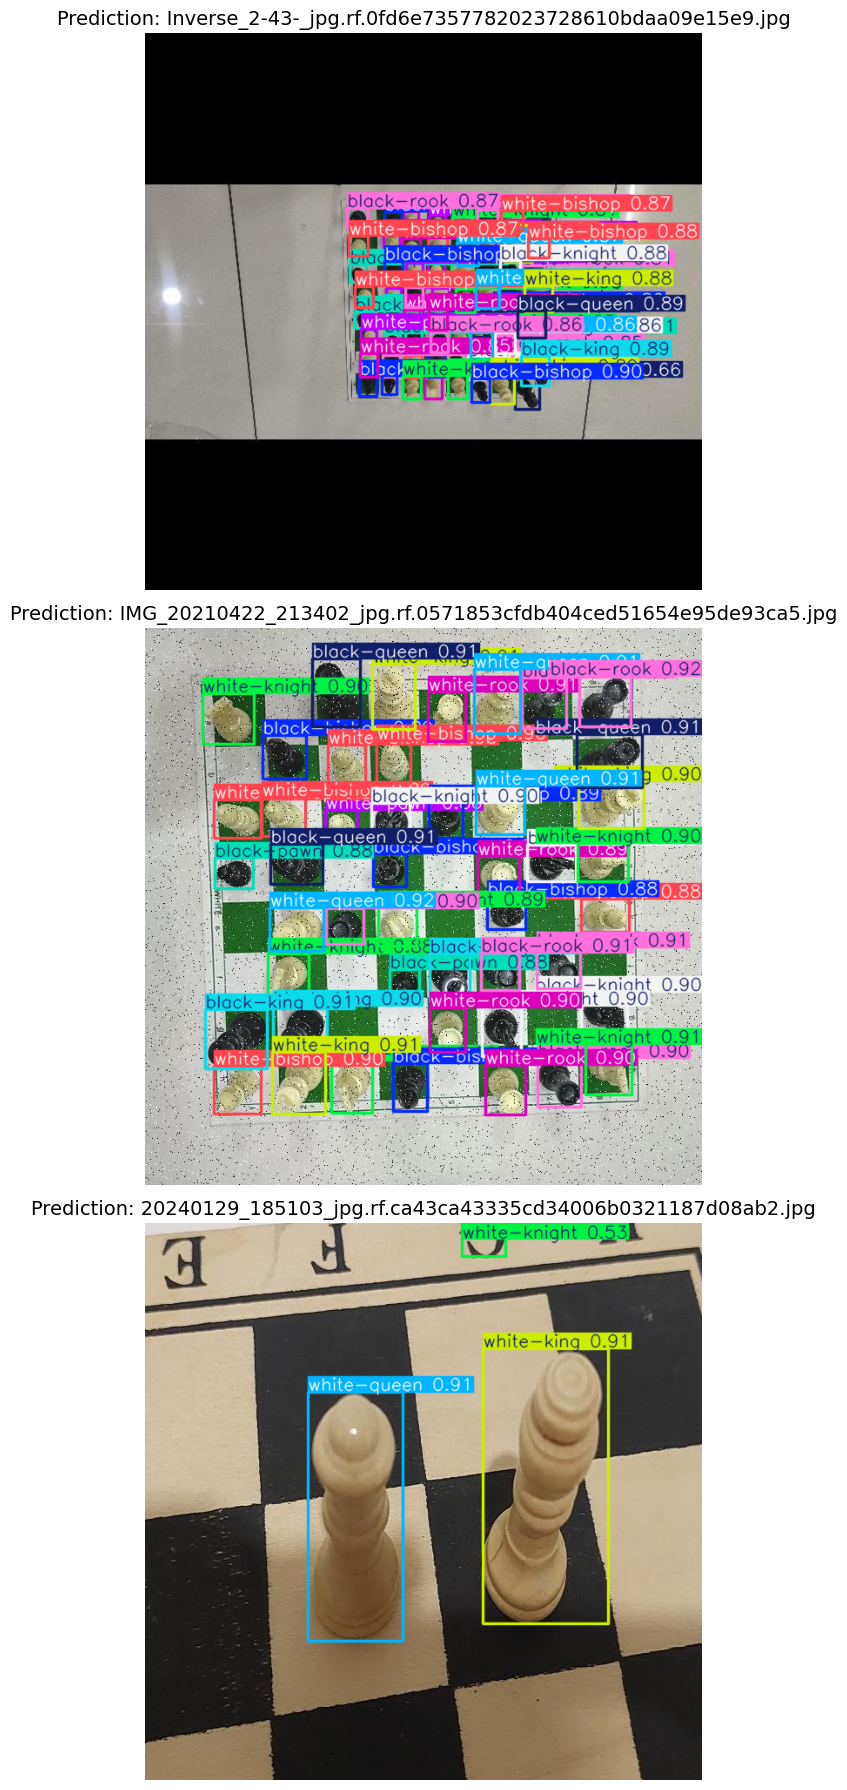

In [ ]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

run_name = 'chess_rtdetr_l_20260101_1829' 

# Project root directory on Drive
drive_root = '/content/drive/MyDrive/Deep_Learning'

# Construct full paths
run_dir = os.path.join(drive_root, 'runs', run_name)
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

print(f"Inspecting results from: {run_dir}")

# Check if run directory exists
if not os.path.exists(run_dir):
    print(f"Error: The folder '{run_name}' was not found in {os.path.join(drive_root, 'runs')}")
    print("Please check the folder name in your Google Drive and update run_name.")
else:
    # Locate test images
    drive_test_search = os.path.join(drive_root, 'datasets', '*', 'test', 'images')
    found_drive_test = glob.glob(drive_test_search)

    if found_drive_test:
        test_images_path = found_drive_test[0]
        print(f"Test images found in Drive: {test_images_path}")
    else:
        # Fallback: local storage
        local_test_path = '/content/datasets/c1-zhnfm-1/test/images'
        if not os.path.exists(local_test_path):
            local_test_path = '/content/datasets/c1-zhnfm-1/valid/images'
        test_images_path = local_test_path

        if os.path.exists(test_images_path):
            print(f"Test images found locally: {test_images_path}")
        else:
            print("Error: Test images could not be found in Drive or local storage.")

    def display_training_metrics(): # Displays standard plots generated by Ultralytics during training.

        print("\n" + "=" * 20 + " 1. TRAINING METRICS " + "=" * 20)

        # Standard Ultralytics output plots
        plots_to_show = [
            ('results.png', 'Loss and Metrics Curves'),
            ('confusion_matrix_normalized.png', 'Confusion Matrix (Normalized)'),
            ('labels.jpg', 'Dataset Labels')
        ]

        for filename, title in plots_to_show:
            filepath = os.path.join(run_dir, filename)
            if os.path.exists(filepath):
                print(f"\n--- {title} ---")
                display(Image(filename=filepath, width=800))
            else:
                print(f"WARNING: {filename} was not found. It may only be generated at the end of training.")

    def run_visual_inference(num_images=3):
        
        print("\n" + "=" * 20 + " 2. VISUAL PREDICTIONS (TEST SET) " + "=" * 20)

        # Check if weights exist
        if not os.path.exists(best_model_path):
            print(f"Error: Best model weights not found at: {best_model_path}")
            return

        # The YOLO class can load RT-DETR weights for inference
        model = YOLO(best_model_path)

        # Collect test images
        all_images = glob.glob(f"{test_images_path}/*.jpg")

        if len(all_images) == 0:
            print(f"Error: No images found in {test_images_path}")
            return

        # Randomly select images
        selected_images = random.sample(all_images, min(len(all_images), num_images))

        # Run inference
        results = model.predict(
            source=selected_images,
            conf=0.25,
            iou=0.45,
            save=False,
            verbose=False
        )

        # Display predictions
        plt.figure(figsize=(15, 6 * num_images))

        for i, r in enumerate(results):
            im_bgr = r.plot(line_width=2, font_size=2)
            im_rgb = im_bgr[..., ::-1]  # Convert BGR to RGB

            plt.subplot(num_images, 1, i + 1)
            plt.imshow(im_rgb)
            plt.axis('off')
            plt.title(f"Prediction: {os.path.basename(selected_images[i])}", fontsize=14)

        plt.tight_layout()
        plt.show()

    display_training_metrics()
    run_visual_inference(num_images=3)


# Analyze Model Confidence

Loading model from: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20260101_1829/weights/best.pt
Analyzing images in: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images
Processing 976 images sequentially to save memory...


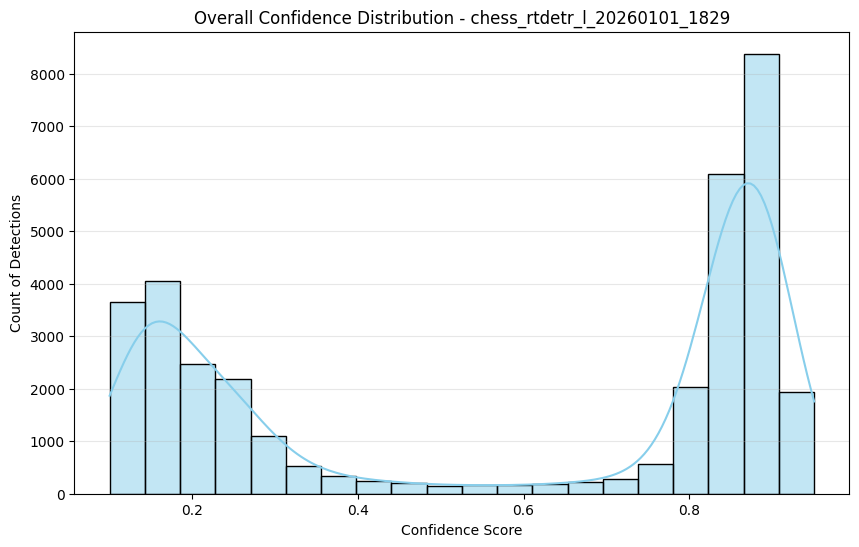



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



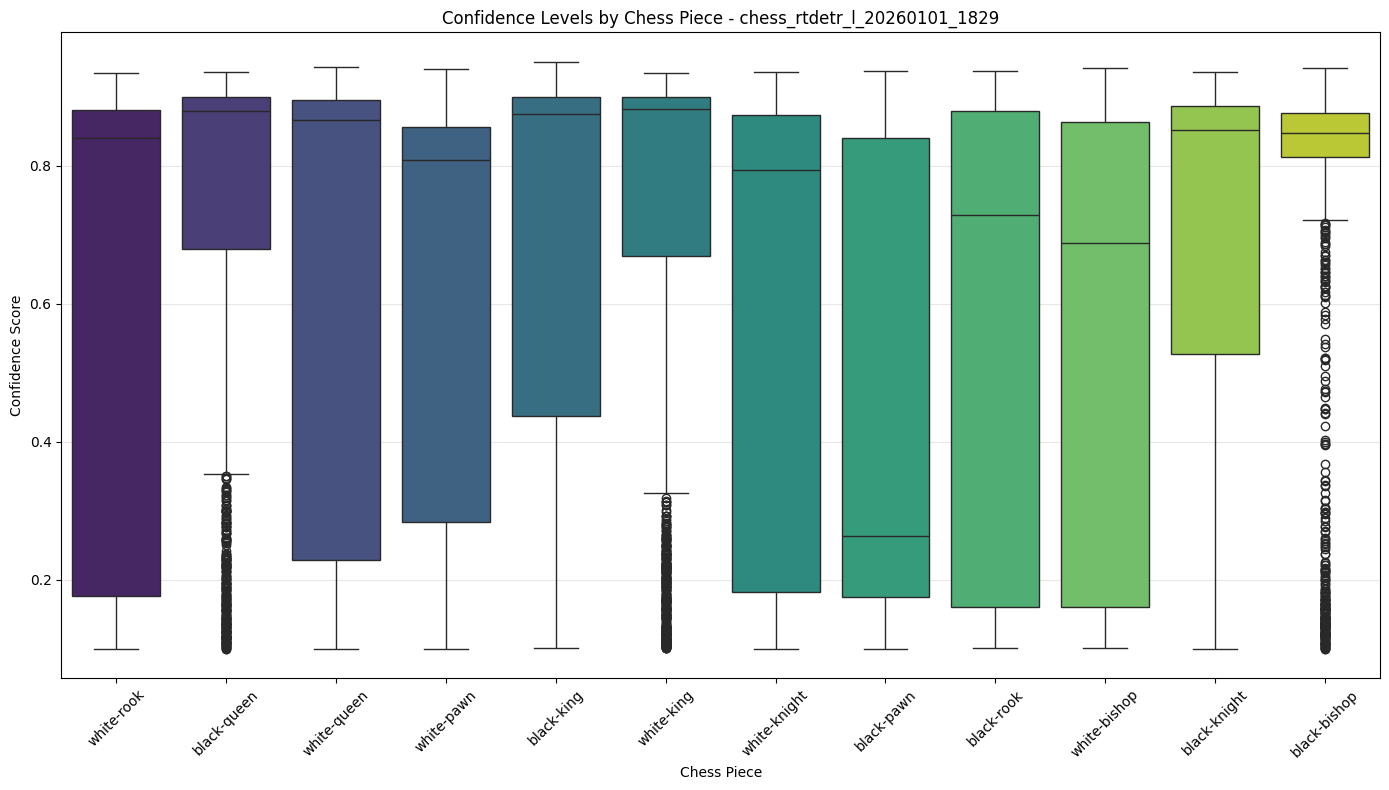

In [ ]:
run_name = 'chess_rtdetr_l_20260101_1829'

drive_root = '/content/drive/MyDrive/Deep_Learning'
run_dir = os.path.join(drive_root, 'runs', run_name)
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

# Locate Test Images
drive_test_search = os.path.join(drive_root, 'datasets', '*', 'test', 'images')
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    test_image_dir = found_drive_test[0]
else:
    test_image_dir = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(test_image_dir):
        test_image_dir = '/content/datasets/c1-zhnfm-1/valid/images'

def plot_confidence_analysis(model_path, images_dir):
    # Clear Memory Before Starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    if not os.path.exists(model_path):
        print(f"Error: Model weights not found at {model_path}")
        return

    print(f"Loading model from: {model_path}")
    print(f"Analyzing images in: {images_dir}")

    # Load Model
    model = YOLO(model_path)
    image_files = glob.glob(f"{images_dir}/*.jpg")

    if not image_files:
        print("No images found.")
        return

    # Collect data
    all_confs = []
    all_classes = []

    print(f"Processing {len(image_files)} images sequentially to save memory...")

    # We loop through files manually to ensure memory is released after each image
    for i, img_path in enumerate(image_files):
        try:
            results = model.predict(img_path, conf=0.1, verbose=False, device=0)

            for r in results:
                if r.boxes:
                    confs = r.boxes.conf.cpu().numpy()
                    clss = r.boxes.cls.cpu().numpy().astype(int)
                    class_names = r.names

                    all_confs.extend(confs)
                    all_classes.extend([class_names[c] for c in clss])
        except Exception as e:
            print(f"Skipping image {i} due to error: {e}")
            continue

    # Create DataFrame for plotting
    df = pd.DataFrame({'Confidence': all_confs, 'Class': all_classes})

    if df.empty:
        print("No detections made on the test set.")
        return

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Confidence', bins=20, kde=True, color='skyblue')
    plt.title(f'Overall Confidence Distribution - {run_name}')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count of Detections')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Class', y='Confidence', palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f'Confidence Levels by Chess Piece - {run_name}')
    plt.xlabel('Chess Piece')
    plt.ylabel('Confidence Score')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_confidence_analysis(best_model_path, test_image_dir)

# Advanced Evaluation

Analysis started for run: chess_rtdetr_l_20260101_1829
Model path: /content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20260101_1829/weights/best.pt
Test Images: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

Computing class-wise mAP
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
rt-detr-l summary: 310 layers, 32,008,400 parameters, 0 gradients, 103.5 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 29.3±5.7 MB/s, size: 63.9 KB)
val: Scanning /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 976/976 1.2Mit/s 0.0s
val: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images/IMG_20200909_000652_jpg.rf.915eb2770aef574ef4eae9a12de1e2b8.jpg: 2 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 61/61 7.3it/s 8.3s
                   



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



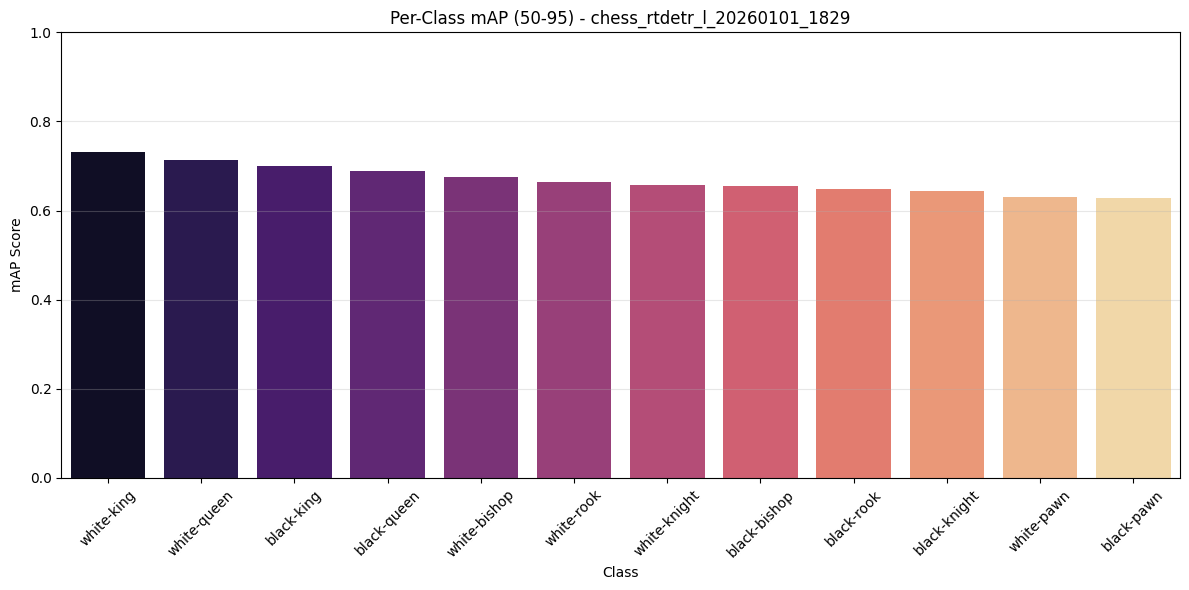


--- Confusion Matrix ---


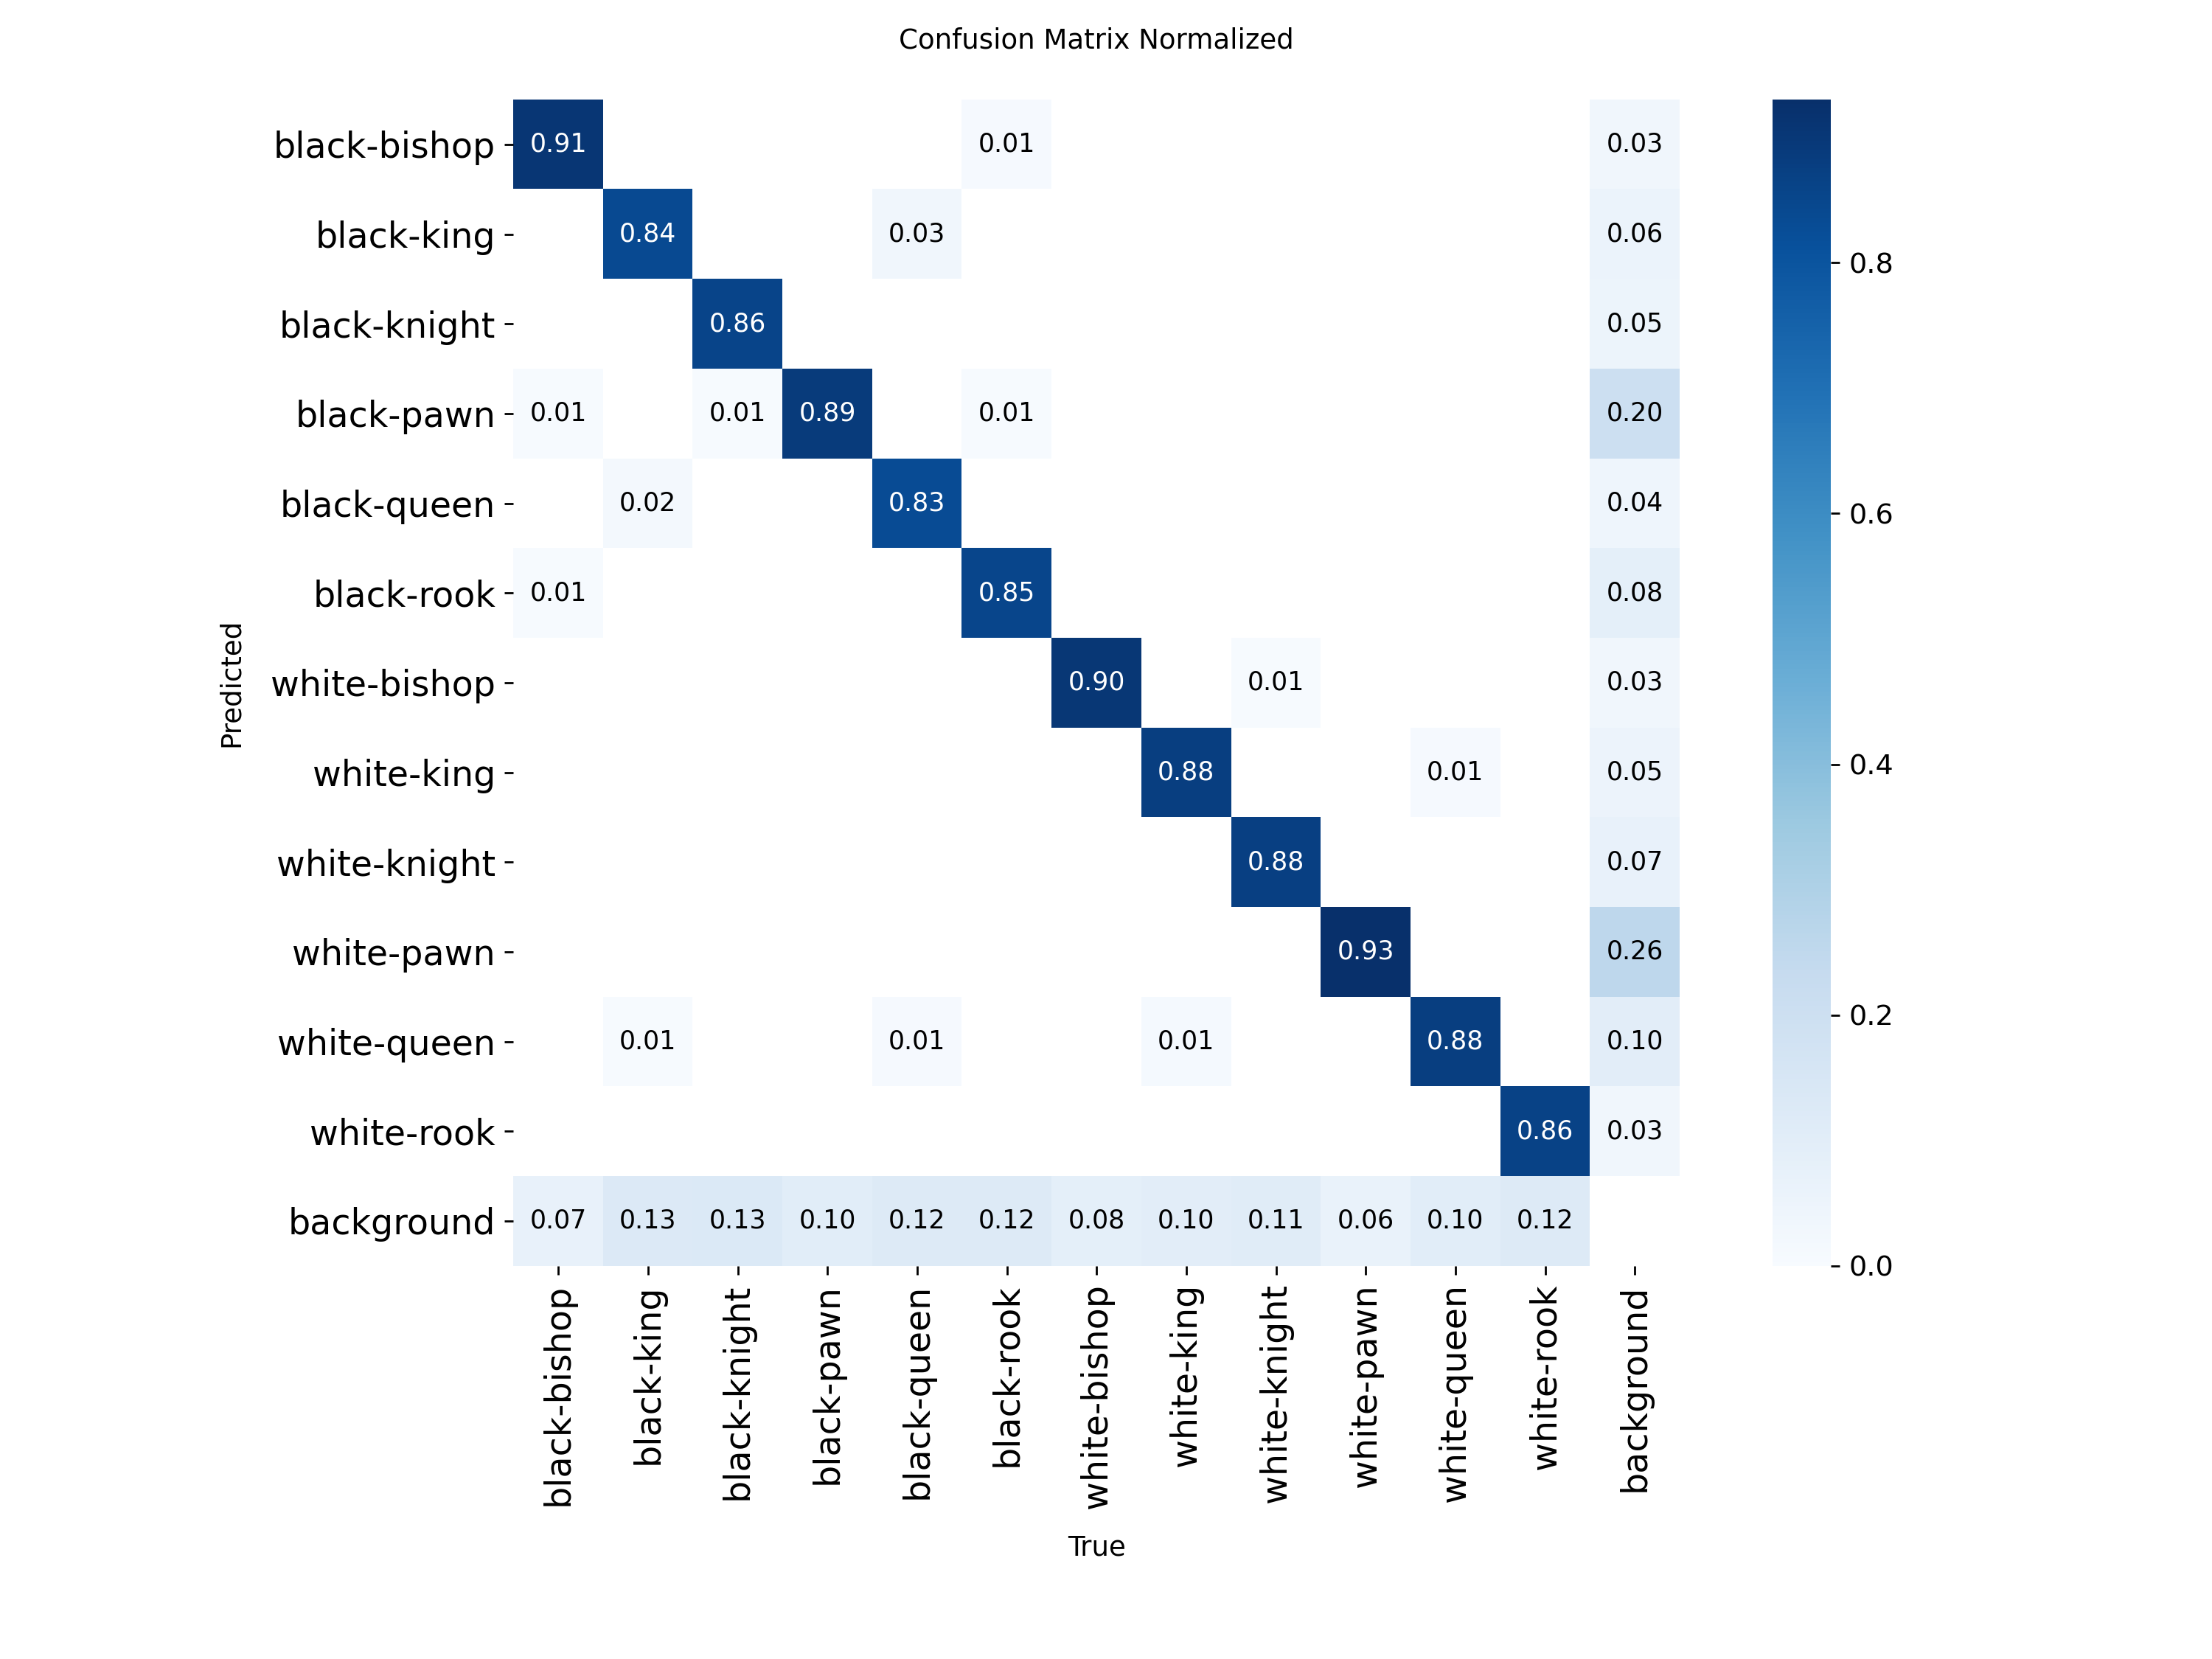


1. Class Distribution Analysis (Ground Truth)




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



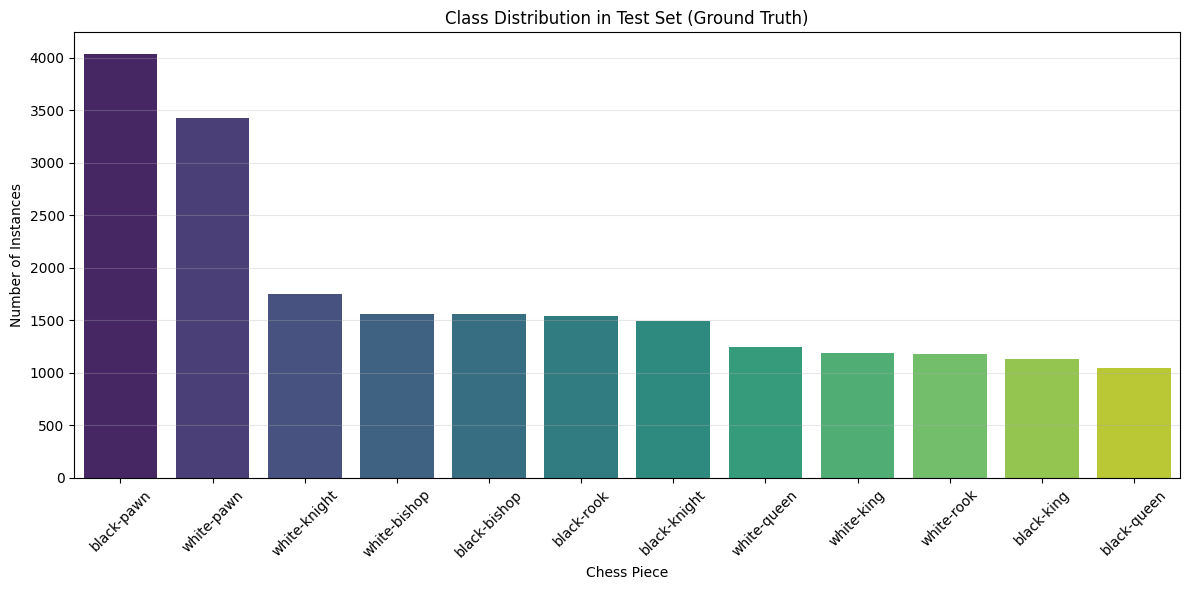

In [ ]:
run_name = 'chess_rtdetr_l_20260101_1829'

drive_root = '/content/drive/MyDrive/Deep_Learning'
run_dir = os.path.join(drive_root, 'runs', run_name)
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

# Locate Images and Labels
drive_test_search = os.path.join(drive_root, 'datasets', '*', 'test', 'images')
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    test_image_dir = found_drive_test[0]
else:
    test_image_dir = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(test_image_dir):
        test_image_dir = '/content/datasets/c1-zhnfm-1/valid/images'

TEST_LABELS_DIR = test_image_dir.replace('images', 'labels')

print(f"Analysis started for run: {run_name}")
print(f"Model path: {best_model_path}")
print(f"Test Images: {test_image_dir}")

def analyze_class_distribution(class_names): # Analyzes and plots the class distribution from ground truth labels in the test set.

    print("\n1. Class Distribution Analysis (Ground Truth)")

    label_files = glob.glob(os.path.join(TEST_LABELS_DIR, "*.txt"))
    if not label_files:
        print("No label files found. Skipping distribution plot.")
        return

    class_counts = Counter()

    for lf in label_files:
        with open(lf, 'r') as f:
            lines = f.readlines()
            for line in lines:
                try:
                    cls_id = int(line.split()[0])
                    # Map ID to name using the model's class names
                    if cls_id < len(class_names):
                        class_counts[class_names[cls_id]] += 1
                except ValueError:
                    continue

    if not class_counts:
        print("No classes found in label files.")
        return

    # Create DataFrame
    df_dist = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count']).reset_index()
    df_dist.columns = ['Class', 'Count']
    df_dist = df_dist.sort_values('Count', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_dist, x='Class', y='Count', palette='viridis')
    plt.title('Class Distribution in Test Set (Ground Truth)')
    plt.xlabel('Chess Piece')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def generate_advanced_plots():
    # Clear GPU memory before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    if not os.path.exists(best_model_path):
        print("Model file not found.")
        return

    # Load Model
    model = YOLO(best_model_path)

    # Standard Metrics (mAP)
    print("\nComputing class-wise mAP")
    # Run validation
    metrics = model.val(
        data=os.path.join(os.path.dirname(os.path.dirname(test_image_dir)), 'data.yaml'),
        split='test',
        verbose=False,
        plots=False
    )

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    class_names = metrics.names
    map5095_per_class = metrics.box.maps

    df_map = pd.DataFrame({
        'Class': [class_names[i] for i in range(len(map5095_per_class))],
        'mAP 50-95': map5095_per_class
    }).sort_values('mAP 50-95', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_map, x='Class', y='mAP 50-95', palette='magma')
    plt.title(f'Per-Class mAP (50-95) - {run_name}')
    plt.xlabel('Class')
    plt.ylabel('mAP Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    conf_matrix_path = os.path.join(run_dir, 'confusion_matrix_normalized.png')
    if os.path.exists(conf_matrix_path):
        print("\n--- Confusion Matrix ---")
        display(Image(filename=conf_matrix_path, width=800))
        
    # Class Distribution
    analyze_class_distribution(class_names)


generate_advanced_plots()